In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import sctour as sct
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import seaborn as sns
from matplotlib.collections import LineCollection

plt.rcParams["pdf.use14corefonts"] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False

In [2]:
cols = list(map(colors.to_hex, cm.tab20.colors))
cols2 = list(map(colors.to_hex, cm.tab20b.colors))
cols3 = list(map(colors.to_hex, cm.tab20c.colors))

Load the data from organoids (scRNA-seq), and two in vivo datasets (snRNA-seq and scRNA-seq).

In [3]:
##scRNA-seq from organoids
data_vitro_anno = sc.read('../../../scvi_remove_lowUMI/HVG_1000_latent_10_res.h5ad')
data_vitro_anno.obs['celltype'] = data_vitro_anno.obs['celltype'].astype('str')
idx = data_vitro_anno.obs['celltype'].str.startswith('EVT')
cells = data_vitro_anno.obs_names[idx]
meta = data_vitro_anno.obs[idx]
data_vitro = sc.read('../../../ogn_raw_counts_all_cells.h5ad')
data_vitro = data_vitro[cells].copy()
data_vitro.obs = meta.copy()
ctys_order = ['EVT_proliferating', 'EVT_early_1', 'EVT_early_2', 'EVT_early_3',
              'EVT_intermediate_1', 'EVT_intermediate_2',
              'EVT_late_1', 'EVT_late_2', 'EVT_late_3']
data_vitro.obs['celltype'] = data_vitro.obs['celltype'].astype('category')
data_vitro.obs['celltype'].cat.reorder_categories(ctys_order, inplace=True)
data_vitro.uns['celltype_colors'] = ([cols[18]] + [cols3[11]] + [cols[1]] + [cols[19]] +
                                     ['#1d91c0'] + ['#4a6fe3'] +
                                     [cols2[2]] + ['#023fa5'] + ['#0000ff'])
data_vitro.layers['count'] = data_vitro.X.copy()
sc.pp.normalize_total(data_vitro, target_sum=1e4)
sc.pp.log1p(data_vitro)
data_vitro.raw = data_vitro
data_vitro.X = data_vitro.layers['count'].copy()

##snRNA-seq from primary tissue (Arutyunyan et al., Nature 2023)
data_vivo_sn = sc.read('../../../adata_P13_trophoblast_raw_counts_in_raw_normlog_counts_in_X_for_download.h5ad')
data_vivo_sn = data_vivo_sn.raw.to_adata()
sc.pp.calculate_qc_metrics(data_vivo_sn, log1p=False, percent_top=None, inplace=True)
data_vivo_sn.obs['celltype'] = data_vivo_sn.obs['final_annot_all_troph_corrected'].astype(str)
idx = data_vivo_sn.obs['celltype'].isin(['VCT_CCC', 'EVT_1', 'EVT_2', 'iEVT', 'GC'])
data_vivo_sn = data_vivo_sn[idx, :].copy()
data_vivo_sn.obs['celltype'] = data_vivo_sn.obs['celltype'].astype('category')
data_vivo_sn.obs['celltype'].cat.reorder_categories(['VCT_CCC', 'EVT_1', 'EVT_2', 'iEVT', 'GC'], inplace=True)
data_vivo_sn.uns['celltype_colors'] = ['#fb9a99', '#fdbf6f', '#f768a1', '#ff7f00', '#e31a1c']
data_vivo_sn.layers['count'] = data_vivo_sn.X.copy()
sc.pp.normalize_total(data_vivo_sn, target_sum=1e4)
sc.pp.log1p(data_vivo_sn)
data_vivo_sn.raw = data_vivo_sn
data_vivo_sn.X = data_vivo_sn.layers['count'].copy()

##scRNA-seq from primary tissue (Vento-Tormo et al., Nature 2018)
data_vivo_sc = sc.read('../../../Roser_old_data.h5ad')
sc.pp.calculate_qc_metrics(data_vivo_sc, log1p=False, percent_top=None, inplace=True)
idx = (data_vivo_sc.obs['annotation'] == 'EVT').values
data_vivo_sc = data_vivo_sc[idx, :].copy()
data_vivo_sc.obs['celltype'] = data_vivo_sc.obs['location'].astype('category')
data_vivo_sc.obs['celltype'].cat.reorder_categories(['Placenta', 'Decidua'], inplace=True)
data_vivo_sc.uns['celltype_colors'] = ['blue', 'red']
data_vivo_sc.layers['count'] = data_vivo_sc.X.copy()
sc.pp.normalize_total(data_vivo_sc, target_sum=1e4)
sc.pp.log1p(data_vivo_sc)
data_vivo_sc.raw = data_vivo_sc
data_vivo_sc.X = data_vivo_sc.layers['count'].copy()
sc.pp.highly_variable_genes(data_vivo_sc, flavor='seurat_v3', n_top_genes=500, subset=True)

/home/ql312/software/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


To compare the EVT differentiation pathway between the organoids and the primary tissue, a scTour model was first trained based on the EVT cells (VCT_CCC, EVT_1, EVT_2, iEVT, and GC) from the in vivo snRNA-seq dataset. The intersection of genes expressed in this dataset and organoids with the 500 highly variable genes from the second in vivo scRNA-seq dataset were used for model training (473 genes).

The resulting model was then employed to infer the developmental pseudotime of the EVT cells from the first in vivo snRNA-seq dataset, as well as to predict the pseudotime for the in vitro EVT cells in the organoids and for the EVT cells from the second in vivo scRNA-seq dataset.

In [4]:
ggs = data_vivo_sn.var_names.intersection(data_vivo_sc.var_names).intersection(data_vitro.var_names)
print(len(ggs))
data_vivo_sn = data_vivo_sn[:, ggs].copy()

##scTour model training
tnode = sct.train.Trainer(data_vivo_sn, loss_mode='nb')
tnode.train()

##infer and predict pseudotime
data_vivo_sn.obs['ptime'] = sct.train.reverse_time(tnode.get_time())
data_vivo_sc.obs['ptime'] = sct.train.reverse_time(sct.predict.predict_time(tnode, data_vivo_sc))
data_vitro.obs['ptime'] = sct.train.reverse_time(sct.predict.predict_time(tnode, data_vitro))

473


Running using CPU.
Epoch 400: 100%|██████████| 400/400 [12:00<00:00,  1.74s/epoch, train_loss=161, val_loss=166]


Visualize the inferred/predicted pseudotime along the EVT differentiation pathway in vitro and in vivo.

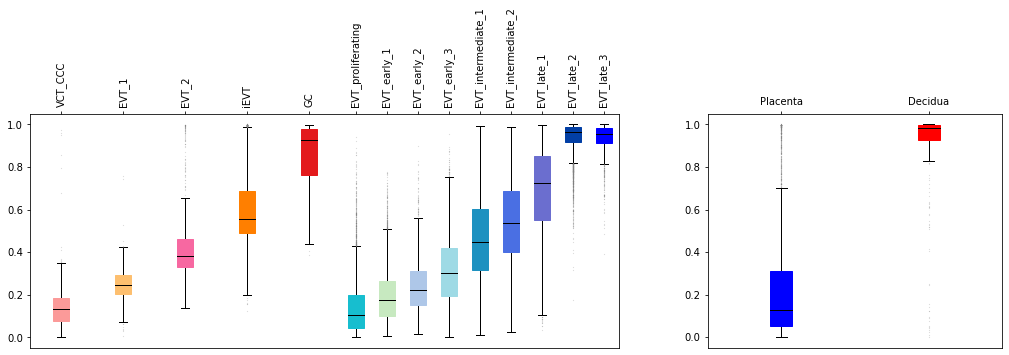

In [5]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 5), gridspec_kw=dict(bottom=0.05, top=0.7, left=0.05, right=0.95, width_ratios=[2, 1]))

##visualize pseudotime of cells from in vivo snRNA-seq and in vitro scRNA-seq datasets
ctys1 = list(data_vivo_sn.obs['celltype'].cat.categories)
ctys2 = list(data_vitro.obs['celltype'].cat.categories)
ctys = ctys1 + ctys2
cls = list(data_vivo_sn.uns['celltype_colors']) + list(data_vitro.uns['celltype_colors'])
axs[0].set_xlim(0, 2*len(ctys1)+len(ctys2))
axs[0].tick_params(axis='x', labelrotation=90)
ts = []
for cty in ctys1:
    ts.append(data_vivo_sn[data_vivo_sn.obs['celltype']==cty, :].obs['ptime'].values)
for cty in ctys2:
    ts.append(data_vitro[data_vitro.obs['celltype']==cty, :].obs['ptime'].values)
bplot = axs[0].boxplot(ts, labels=ctys, patch_artist=True, showfliers=True, vert=True,
                       positions=np.concatenate([np.arange(1, 2*len(ctys1), 2), np.arange(2*len(ctys1)+0.5, 2*len(ctys1)+len(ctys2))]),
                       medianprops={'color': 'black'},
                       flierprops=dict(markersize=0.1, linewidth=0.1, markeredgecolor='gray')
                      )
for patch, color in zip(bplot['boxes'], cls):
    patch.set_color(color)

##visualize pseudotime of cells from in vivo scRNA-seq dataset
ctys3 = ['Placenta', 'Decidua']
ts2 = [data_vivo_sc[data_vivo_sc.obs['celltype']==cty, :].obs['ptime'].values for cty in ctys3]
bplot = axs[1].boxplot(ts2, labels=ctys3, patch_artist=True, showfliers=True, vert=True,
                       medianprops={'color': 'black'},
                       flierprops=dict(markersize=0.1, linewidth=0.1, markeredgecolor='gray')
                      )
for patch, color in zip(bplot['boxes'], data_vivo_sc.uns['celltype_colors']):
    patch.set_color(color)
plt.show()

Visualize the expression dynamics along the pseudotime in vivo and in vitro for genes affected by uNK cytokines.

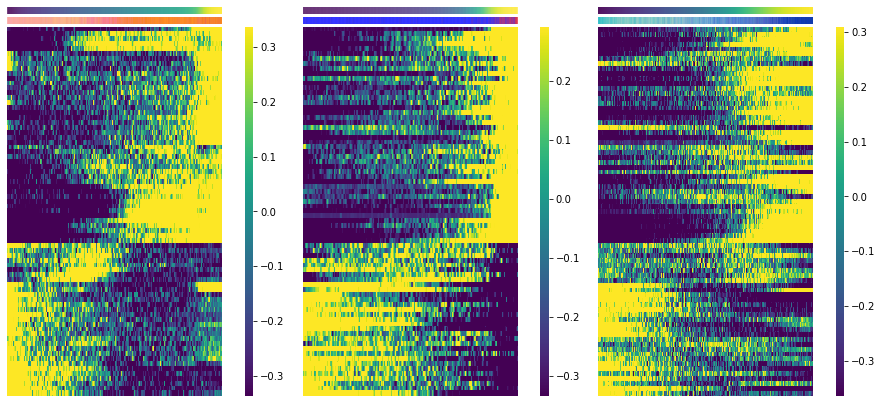

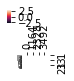

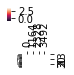

In [7]:
up_ggs = pd.read_csv('../../../EVT_invivo_invitro_DE_gene_overlap_up.csv', header=None)[0].values
down_ggs = pd.read_csv('../../../EVT_invivo_invitro_DE_gene_overlap_down.csv', header=None)[0].values
ggs = np.concatenate([up_ggs, down_ggs])

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 6), gridspec_kw=dict(bottom=0.05, top=0.95))
for i, adata in enumerate([data_vivo_sn, data_vivo_sc, data_vitro]):
    adata = adata.raw.to_adata()
    adata = adata[np.argsort(adata.obs['ptime'].values), :]
    mat = adata[:, ggs].X.A if i != 1 else adata[:, ggs].X.copy()
    mm = mat.mean(0)
    std = np.std(mat, axis=0)
    mat = (mat - mm)/std
    mat[mat > 10] = 10
    mat = mat.T
    weights = np.ones(30) / 30
    for m in range(mat.shape[0]):
        mat[m] = np.convolve(mat[m], weights, mode="same")
    
    laxs = axs[i].get_subplotspec().subgridspec(nrows=3, ncols=2, height_ratios=[0.02, 0.02, 1], width_ratios=[1, 0.04], hspace=0.02)
    axs[i].remove()
    ax1 = fig.add_subplot(laxs[2, 0])
    ax2 = fig.add_subplot(laxs[2, 1])
    
    if i == 0:
        mat1 = mat[:len(up_ggs)].copy()
        mat2 = mat[len(up_ggs):].copy()
        sn1 = sns.clustermap(mat1, row_cluster=True, col_cluster=False, method='average', figsize=(1, 1))
        sn2 = sns.clustermap(mat2, row_cluster=True, col_cluster=False, method='average', figsize=(1, 1))
        idx1 = sn1.dendrogram_row.reordered_ind
        idx2 = sn2.dendrogram_row.reordered_ind
        idx2 = [ix+len(up_ggs) for ix in idx2]
        idx = idx1 + idx2
    mat = mat[idx]
    vmin = np.percentile(mat, 20)
    vmax = np.percentile(mat, 80)
    sns.heatmap(mat, cmap='viridis', vmin=vmin, vmax=vmax,
                rasterized=True, yticklabels=False, xticklabels=False,
                ax=ax1, cbar_ax=ax2)
    
    ##add pseudotime and cell type info
    for j in range(2):
        ax3 = fig.add_subplot(laxs[j, 0])
        ax3.set_ylim(0, 1)
        ax3.set_xlim(0, adata.n_obs)
        ax3.set_axis_off()
        lns = []
        for k in range(adata.n_obs):
            lns.append([(k+0.5, 0), (k+0.5, 1)])
        if j == 0:
            lns = LineCollection(lns, linewidths=0.1, cmap='viridis', array=adata.obs['ptime'].values)
        else:
            cls = pd.DataFrame(adata.uns['celltype_colors'],
                               index=adata.obs['celltype'].cat.categories).loc[adata.obs['celltype'].values, 0].values
            lns = LineCollection(lns, linewidths=0.1, color=cls)
        ax3.add_collection(lns)
plt.show()      